# Training a Model for Building Detection Using HOG and SVM


## Super Special Thanks to the Following:
### Dataset for Training:
https://project.inria.fr/aerialimagelabeling/files/

### Lots of Code and Tutorial
https://www.udemy.com/autonomous-cars-deep-learning-and-computer-vision-in-python/

### Other Sources of Helpful Code and Hints:
https://news.developer.nvidia.com/ai-helps-detect-disaster-damage-from-satellite-imagery/  
https://research.fb.com/wp-content/uploads/2018/11/From-Satellite-Imagery-to-Disaster-Insights.pdf  
https://stackoverflow.com/questions/18262293/how-to-open-every-file-in-a-folder  
https://www.pyimagesearch.com/2018/04/16/keras-and-convolutional-neural-networks-cnns/  
https://ai.stackexchange.com/questions/3938/how-to-handle-images-of-large-sizes-in-cnn/4191  
https://towardsdatascience.com/boost-your-cnn-image-classifier-performance-with-progressive-resizing-in-keras-a7d96da06e20  
https://www.kaggle.com/lopuhin/full-pipeline-demo-poly-pixels-ml-poly  
https://gist.github.com/bigsnarfdude/d811e31ee17495f82f10db12651ae82d  


# DISPLAY IMAGES

In [1]:
import glob
import cv2
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from skimage.feature import hog 
import os
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
#import training dataset of buildings
build_pos = glob.glob('../images/training/build_pos/0/*.jpg')
build_neg = glob.glob('../images/training/build_neg/0/*.jpg')


In [3]:
build_pos

['../images/training/build_pos/0/austin17.jpg',
 '../images/training/build_pos/0/chicago11.jpg',
 '../images/training/build_pos/0/tyrol-w27.jpg',
 '../images/training/build_pos/0/tyrol-w33.jpg',
 '../images/training/build_pos/0/kitsap10.jpg',
 '../images/training/build_pos/0/tyrol-w5.jpg',
 '../images/training/build_pos/0/vienna3.jpg',
 '../images/training/build_pos/0/vienna2.jpg',
 '../images/training/build_pos/0/tyrol-w4.jpg',
 '../images/training/build_pos/0/kitsap11.jpg',
 '../images/training/build_pos/0/tyrol-w32.jpg',
 '../images/training/build_pos/0/tyrol-w26.jpg',
 '../images/training/build_pos/0/chicago10.jpg',
 '../images/training/build_pos/0/austin16.jpg',
 '../images/training/build_pos/0/austin28.jpg',
 '../images/training/build_pos/0/austin14.jpg',
 '../images/training/build_pos/0/chicago12.jpg',
 '../images/training/build_pos/0/tyrol-w30.jpg',
 '../images/training/build_pos/0/tyrol-w24.jpg',
 '../images/training/build_pos/0/kitsap13.jpg',
 '../images/training/build_pos/0/

In [4]:
build_neg

['../images/training/build_neg/0/austin17.jpg',
 '../images/training/build_neg/0/chicago11.jpg',
 '../images/training/build_neg/0/tyrol-w27.jpg',
 '../images/training/build_neg/0/tyrol-w33.jpg',
 '../images/training/build_neg/0/kitsap10.jpg',
 '../images/training/build_neg/0/tyrol-w5.jpg',
 '../images/training/build_neg/0/vienna3.jpg',
 '../images/training/build_neg/0/vienna2.jpg',
 '../images/training/build_neg/0/tyrol-w4.jpg',
 '../images/training/build_neg/0/kitsap11.jpg',
 '../images/training/build_neg/0/tyrol-w32.jpg',
 '../images/training/build_neg/0/tyrol-w26.jpg',
 '../images/training/build_neg/0/chicago10.jpg',
 '../images/training/build_neg/0/austin16.jpg',
 '../images/training/build_neg/0/austin28.jpg',
 '../images/training/build_neg/0/austin14.jpg',
 '../images/training/build_neg/0/chicago12.jpg',
 '../images/training/build_neg/0/tyrol-w30.jpg',
 '../images/training/build_neg/0/tyrol-w24.jpg',
 '../images/training/build_neg/0/kitsap13.jpg',
 '../images/training/build_neg/0/

In [5]:
len(build_pos)

180

In [6]:
len(build_neg)

180

## This section for testing just one image

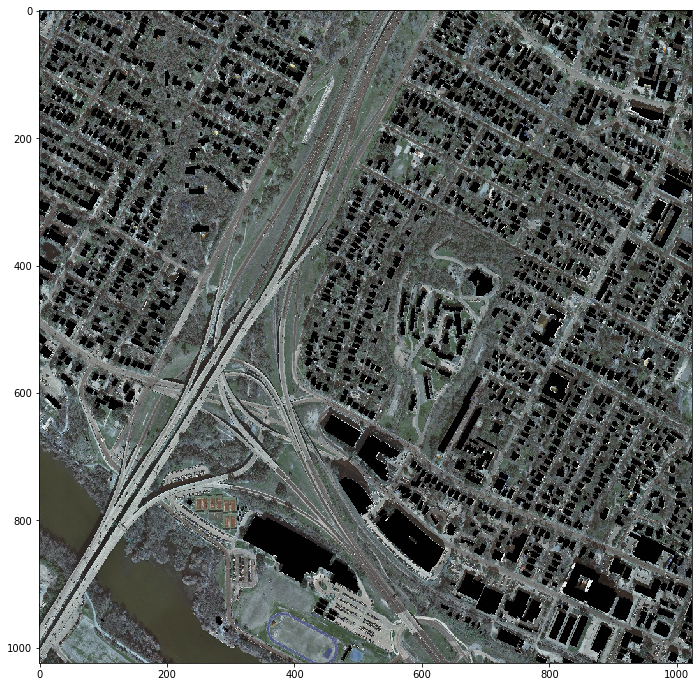

In [40]:
# random image
image_color = cv2.imread(build_pos[31]) 
plt.figure(figsize=(12,12))
plt.imshow(image_color)

(1024, 1024)

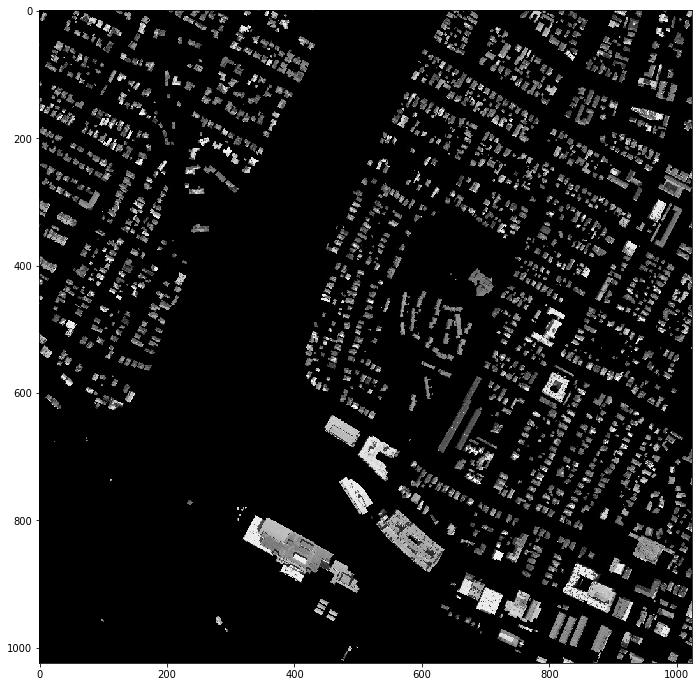

In [34]:
# same random image - grayscale
image_gray = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,12))
plt.imshow(image_gray, cmap = 'gray')
image_gray.shape

## Get HOG Features

In [35]:
# histogram oriented gradients
# image must be greyscale
# https://kite.com/python/docs/skimage.feature._hog.hog

#Start timing
import time

start_time = time.time()

features, hog_image = hog(image_gray, 
                          orientations = 11, 
                          pixels_per_cell = (16, 16), 
                          cells_per_block = (2, 2), 
                          transform_sqrt = False, 
                          visualize = True,  # this is to return an image as well as the feature vector
                          feature_vector = True)
# this shows the number of features per one image
features.shape 

elapsed_time = time.time() - start_time
elapsed_min = elapsed_time / 60
print(f'Total Time: {round(elapsed_min, 3)} minutes.')

Total Time: 0.013 minutes.


In [36]:
features.shape

(174636,)

In [37]:
hog_image.shape

(1024, 1024)

In [38]:
hog_image

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

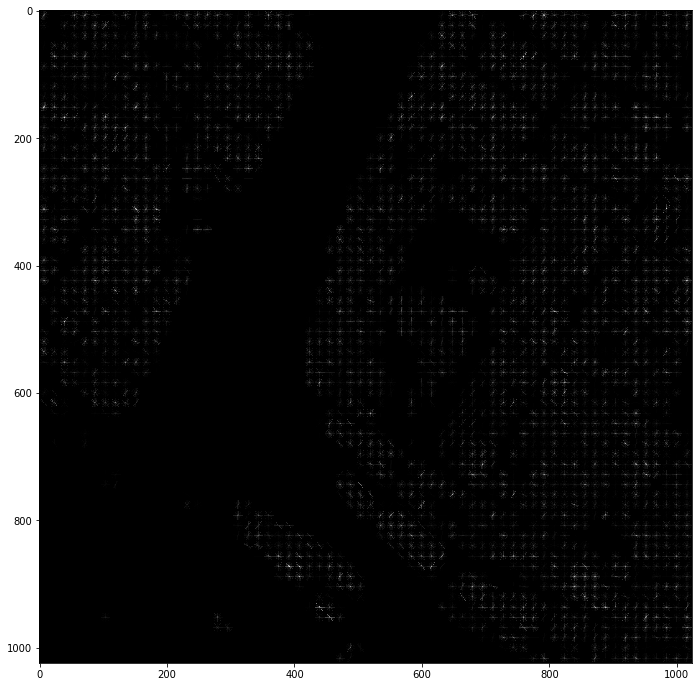

In [39]:
plt.figure(figsize=(12,12))
plt.imshow(hog_image, cmap = 'gray')


## Get HOG Features for All Images

### Positive Class

In [14]:
# list to store all of the features
build_pos_hog_accum = []

#Start timing
start_time = time.time()

# take all of the images and get and store hog features
for i in build_pos:
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    build_pos_hog_feature, build_hog_pos_img = hog(image_gray, 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    build_pos_hog_accum.append(build_pos_hog_feature)

#Finish time
elapsed_time = time.time() - start_time
elapsed_min = elapsed_time / 60
print(f'Total Time: {round(elapsed_min, 3)} minutes.')

Total Time: 2.504 minutes.


In [15]:
X_build_pos = np.vstack(build_pos_hog_accum).astype(np.float64)  

In [16]:
# ones because all of these are the positive class
y_build_pos = np.ones(len(X_build_pos))

In [17]:
X_build_pos.shape

(180, 174636)

In [18]:
X_build_pos

array([[0.30517186, 0.00246144, 0.30517186, ..., 0.23938185, 0.08655545,
        0.12716044],
       [0.33758252, 0.0681922 , 0.04775961, ..., 0.06601437, 0.00121642,
        0.13157664],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.00128907, 0.        , 0.00045575, ..., 0.2949859 , 0.15608342,
        0.21558579],
       [0.        , 0.        , 0.        , ..., 0.24757314, 0.06711542,
        0.10871701],
       [0.        , 0.        , 0.        , ..., 0.1851421 , 0.15693672,
        0.22653057]])

In [19]:
y_build_pos.shape

(180,)

### Negative Class

In [20]:
build_neg_hog_accum = []

#Start timing
start_time = time.time()

for i in build_neg:
    #changed this from image_color to image_gray because the image is already in grayscale
    image_color = mpimg.imread(i)
    image_gray  = cv2.cvtColor(image_color, cv2.COLOR_BGR2GRAY)

    build_neg_hog_feature, build_neg_hog_img = hog(image_gray, 
                                    orientations = 11, 
                                    pixels_per_cell = (16, 16), 
                                    cells_per_block = (2, 2), 
                                    transform_sqrt = False, 
                                    visualize = True, 
                                    feature_vector = True)
                
    build_neg_hog_accum.append(build_neg_hog_feature)

#Finish time
elapsed_time = time.time() - start_time
elapsed_min = elapsed_time / 60
print(f'Total Time: {round(elapsed_min, 3)} minutes.')

Total Time: 2.646 minutes.


In [21]:

X_build_neg = np.vstack(build_neg_hog_accum).astype(np.float64)  
# zeros because negative class
y_build_neg = np.zeros(len(X_build_neg))



In [22]:
X_build_neg.shape

(180, 174636)

In [23]:
X_build_neg

array([[0.15339261, 0.10533512, 0.04098707, ..., 0.06003242, 0.00978363,
        0.02207903],
       [0.27054751, 0.0433457 , 0.02880044, ..., 0.10204037, 0.08056313,
        0.11422953],
       [0.20621796, 0.13055215, 0.16949442, ..., 0.30872722, 0.11638577,
        0.04735237],
       ...,
       [0.11688743, 0.10829066, 0.11941914, ..., 0.19634353, 0.15158351,
        0.12905568],
       [0.20458237, 0.16303843, 0.07972055, ..., 0.21844124, 0.18251679,
        0.16091197],
       [0.09031695, 0.04098753, 0.12239985, ..., 0.10182332, 0.10770662,
        0.13458408]])

In [24]:
y_build_neg.shape

(180,)

In [25]:

X = np.vstack((X_build_pos, X_build_neg))
X.shape

(360, 174636)

In [26]:
y = np.hstack((y_build_pos, y_build_neg))
y.shape

(360,)

## SVM Classifier Training

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)

In [28]:
# These were the best results from multiple gridsearches, feel free to change
param_grid = {'C': [1], 'gamma': [0.001], 'kernel': ['rbf']} 


grid = GridSearchCV(SVC(),param_grid,refit=True,verbose=4, n_jobs=-1)

grid.fit(X_train,y_train)
print(grid.best_params_)
print()
print(grid.best_estimator_)


Fitting 3 folds for each of 1 candidates, totalling 3 fits


/Users/chris/anaconda3/envs/tensor/lib/python3.6/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    9.6s finished


{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


### Use Joblib to Export the Best Params Fitted Model

In [29]:
import joblib

# Save to file in the current working directory
directory = os.path.relpath('../data/')

In [95]:
file_to_save = "grid_svc_trained_model.pkl"
joblib.dump(grid, (directory+'/'+file_to_save))

['../data/grid_svc_trained_model.pkl']

In [31]:
# # Only if loading the file later!
# # Load from file
# file_to_load = 'grid_svc_trained_model.pkl'
# model_import = joblib.load(file_to_load)
# # afterwards can use the model as it was.

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99        44
         1.0       1.00      0.98      0.99        46

    accuracy                           0.99        90
   macro avg       0.99      0.99      0.99        90
weighted avg       0.99      0.99      0.99        90



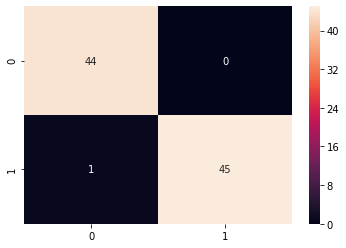

In [32]:
grid_predictions = grid.predict(X_test)
cm = confusion_matrix(y_test, grid_predictions)
sns.heatmap(cm, annot=True)
print(classification_report(y_test,grid_predictions))

## Outline buildings

#### Currently Not Working Properly!! :(

**To Do:**  
- Test on an original image, but resize
- SVC is not classifying properly, it is classifying an entire image as 1 or 0, instead of masked regions

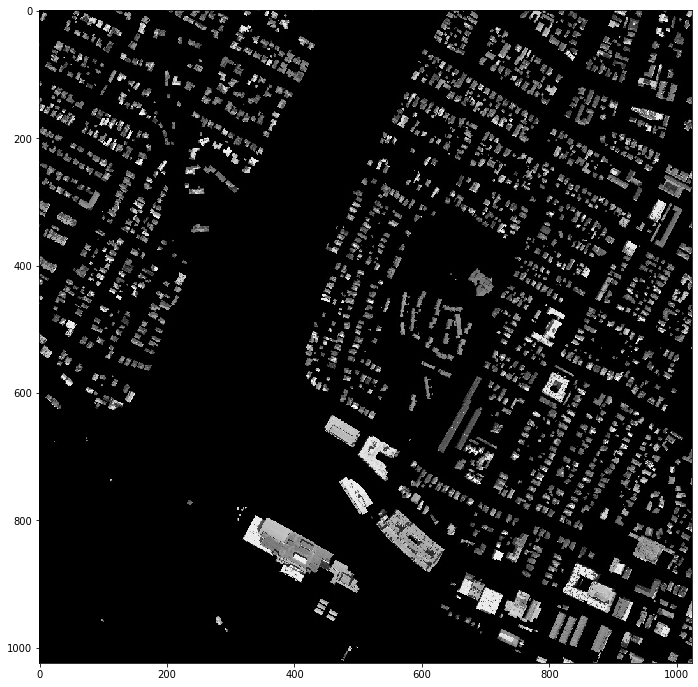

In [55]:
test_image = mpimg.imread('../images/training/build_pos/0/austin11.jpg')
test_image_gray  = cv2.cvtColor(test_image, cv2.COLOR_BGR2GRAY)
plt.figure(figsize=(12,12))
plt.imshow(test_image_gray, cmap='gray')
test_image_gray = test_image_gray.astype(np.float32)

In [56]:
print(test_image_gray.shape)
test_image_gray

(1024, 1024)


array([[  2.,   0.,   0., ..., 105.,  76.,  87.],
       [  0.,   0.,   1., ..., 113., 158., 134.],
       [  1.,   0.,   0., ..., 187., 186., 185.],
       ...,
       [  0.,   0.,   0., ...,  58.,  44.,  48.],
       [  0.,   0.,   0., ...,  92.,  39., 166.],
       [  0.,   0.,   0., ..., 108.,  55., 152.]], dtype=float32)

In [57]:
hog_test, hog_test_img = hog(test_image_gray, 
                                orientations = 11, 
                                pixels_per_cell = (16, 16), 
                                cells_per_block = (2, 2), 
                                transform_sqrt = False, 
                                visualize = True, 
                                feature_vector = True)

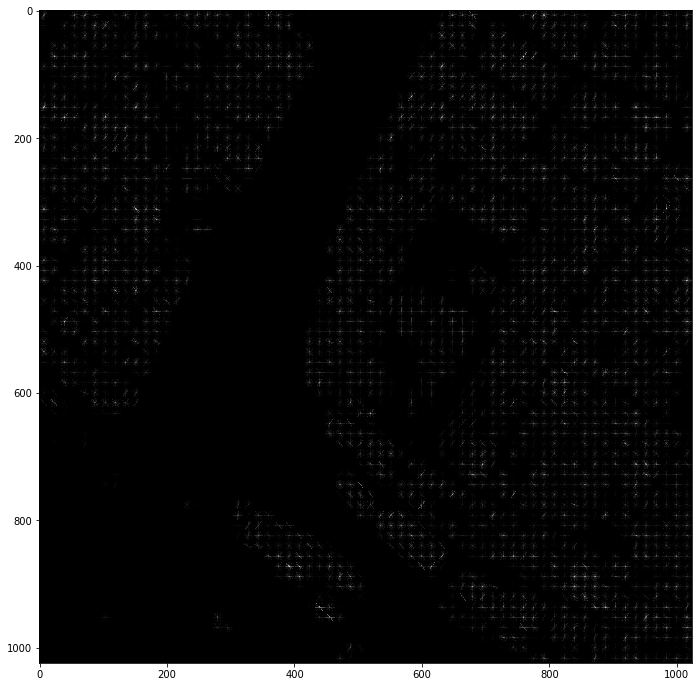

In [58]:
plt.figure(figsize=(12,12))
plt.imshow(hog_test_img, cmap='gray')

In [59]:
hog_test.shape

(174636,)

In [60]:
X_test_validator = hog_test.astype(np.float64)
X_test_validator.shape

(174636,)

(1024, 1024, 3)

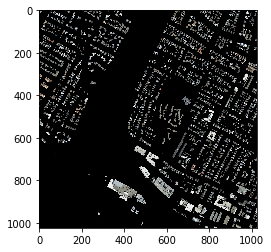

In [61]:
h_start = 0
h_stop = 1024

pixels_in_cell = 16
HOG_orientations = 11
cells_in_block = 2
cells_in_step = 3 


masked_region = test_image[h_start:h_stop,:,:]
plt.imshow(masked_region)
masked_region.shape


In [62]:
resizing_factor = 2
masked_region_shape = masked_region.shape
L = masked_region_shape[1]/resizing_factor
W = masked_region_shape[0]/resizing_factor

(512, 512, 3)


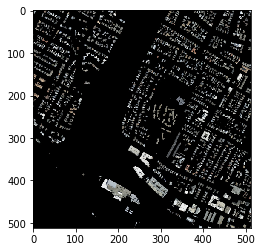

In [63]:
masked_region_resized = cv2.resize(masked_region, (np.int(L), np.int(W)))
masked_region_resized_R = masked_region_resized[:,:,0]

print(masked_region_resized.shape)
plt.imshow(masked_region_resized)


In [64]:
    
# print(masked_region_resized_R.shape)    
print(f'Test image shape: {test_image.shape}')
# masked_region_hog_feature_all, hog_img = hog(masked_region_resized_R, 
#                                              orientations = 11, 
#                                              pixels_per_cell = (16, 16), 
#                                              cells_per_block = (2, 2), 
#                                              transform_sqrt = False, 
#                                              visualize = True, 
#                                              feature_vector = False)


#Start timing
start_time = time.time()


masked_region_hog_feature_all, hog_img = hog(test_image, 
                                orientations = 11, 
                                pixels_per_cell = (16, 16), 
                                cells_per_block = (2, 2), 
                                transform_sqrt = False, 
                                visualize = True, 
                                feature_vector = False)
                


#Finish time
elapsed_time = time.time() - start_time
elapsed_min = elapsed_time / 60
print(f'Total Time: {round(elapsed_min, 3)} minutes.')

Test image shape: (1024, 1024, 3)
Total Time: 0.016 minutes.


In [83]:
hog_img.shape

(1024, 1024)

In [65]:
masked_region_hog_feature_all.shape

(63, 63, 2, 2, 11)

In [66]:
X_test_validator = masked_region_hog_feature_all.astype(np.float64)  

In [67]:
n_blocks_x = (masked_region_resized_R.shape[1] // pixels_in_cell)+1  
n_blocks_y = (masked_region_resized_R.shape[0] // pixels_in_cell)+1

#nfeat_per_block = orientations * cells_in_block **2 
blocks_in_window = (64 // pixels_in_cell)-1 
    
steps_x = (n_blocks_x - blocks_in_window) // cells_in_step
steps_y = (n_blocks_y - blocks_in_window) // cells_in_step

rectangles_found = []

for xb in range(steps_x):
    for yb in range(steps_y):
        y_position = yb*cells_in_step
        x_position = xb*cells_in_step
            
        hog_feat_sample = masked_region_hog_feature_all[y_position : y_position + blocks_in_window, x_position : x_position + blocks_in_window].ravel()
        x_left = x_position * pixels_in_cell
        y_top = y_position * pixels_in_cell
        print(hog_feat_sample.shape)  
        
        # predict using trained SVM
#        test_prediction = svc_model.predict(hog_feat_sample.reshape(1,-1))
        test_prediction = grid.predict(masked_region_hog_feature_all.reshape(1,-1))
        
        if test_prediction == 1: 
            rectangle_x_left = np.int(x_left * resizing_factor)
            rectangle_y_top = np.int(y_top * resizing_factor)
            window_dim = np.int(64 * resizing_factor)
            rectangles_found.append(((rectangle_x_left, rectangle_y_top + h_start),(rectangle_x_left + window_dim, rectangle_y_top + window_dim + h_start)))
                

(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)
(396,)


In [68]:
rectangles_found

[((0, 0), (128, 128)),
 ((0, 96), (128, 224)),
 ((0, 192), (128, 320)),
 ((0, 288), (128, 416)),
 ((0, 384), (128, 512)),
 ((0, 480), (128, 608)),
 ((0, 576), (128, 704)),
 ((0, 672), (128, 800)),
 ((0, 768), (128, 896)),
 ((0, 864), (128, 992)),
 ((96, 0), (224, 128)),
 ((96, 96), (224, 224)),
 ((96, 192), (224, 320)),
 ((96, 288), (224, 416)),
 ((96, 384), (224, 512)),
 ((96, 480), (224, 608)),
 ((96, 576), (224, 704)),
 ((96, 672), (224, 800)),
 ((96, 768), (224, 896)),
 ((96, 864), (224, 992)),
 ((192, 0), (320, 128)),
 ((192, 96), (320, 224)),
 ((192, 192), (320, 320)),
 ((192, 288), (320, 416)),
 ((192, 384), (320, 512)),
 ((192, 480), (320, 608)),
 ((192, 576), (320, 704)),
 ((192, 672), (320, 800)),
 ((192, 768), (320, 896)),
 ((192, 864), (320, 992)),
 ((288, 0), (416, 128)),
 ((288, 96), (416, 224)),
 ((288, 192), (416, 320)),
 ((288, 288), (416, 416)),
 ((288, 384), (416, 512)),
 ((288, 480), (416, 608)),
 ((288, 576), (416, 704)),
 ((288, 672), (416, 800)),
 ((288, 768), (4

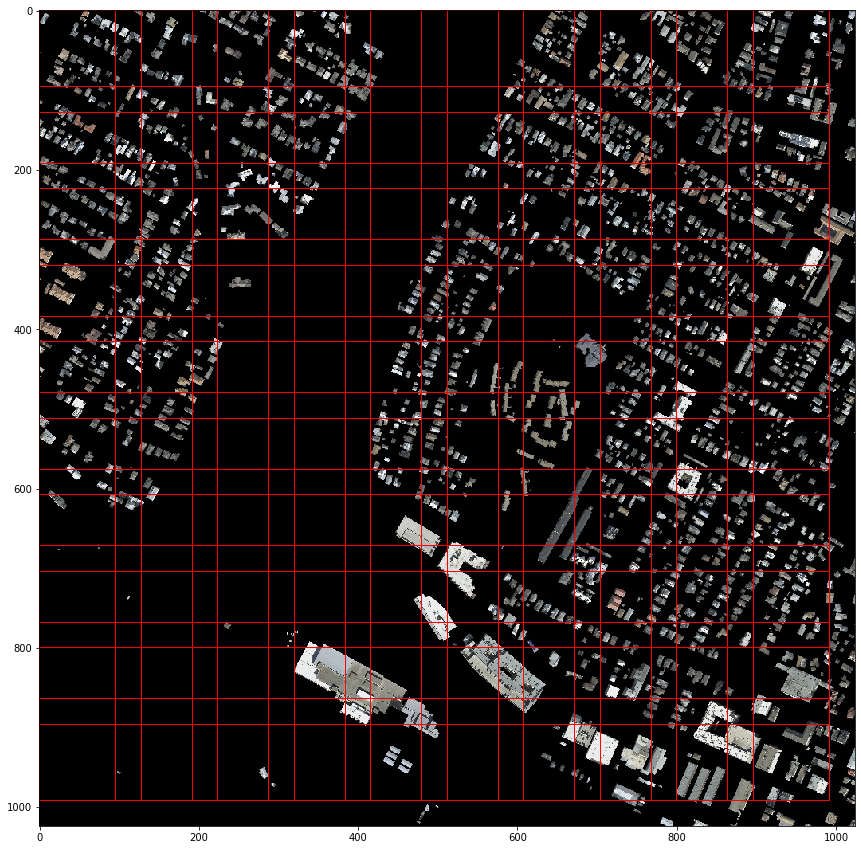

In [77]:
Image_with_Rectangles_Drawn = np.copy(test_image)
    
for rectangle in rectangles_found:
    cv2.rectangle(Image_with_Rectangles_Drawn, rectangle[0], rectangle[1], (255, 0, 0), 1)
plt.figure(figsize=(15,15))
plt.imshow(Image_with_Rectangles_Drawn)
        

### Using Sklearn to draw contours / boxes
Also not working correctly because of SVC

In [78]:
from skimage import measure

KeyboardInterrupt: 

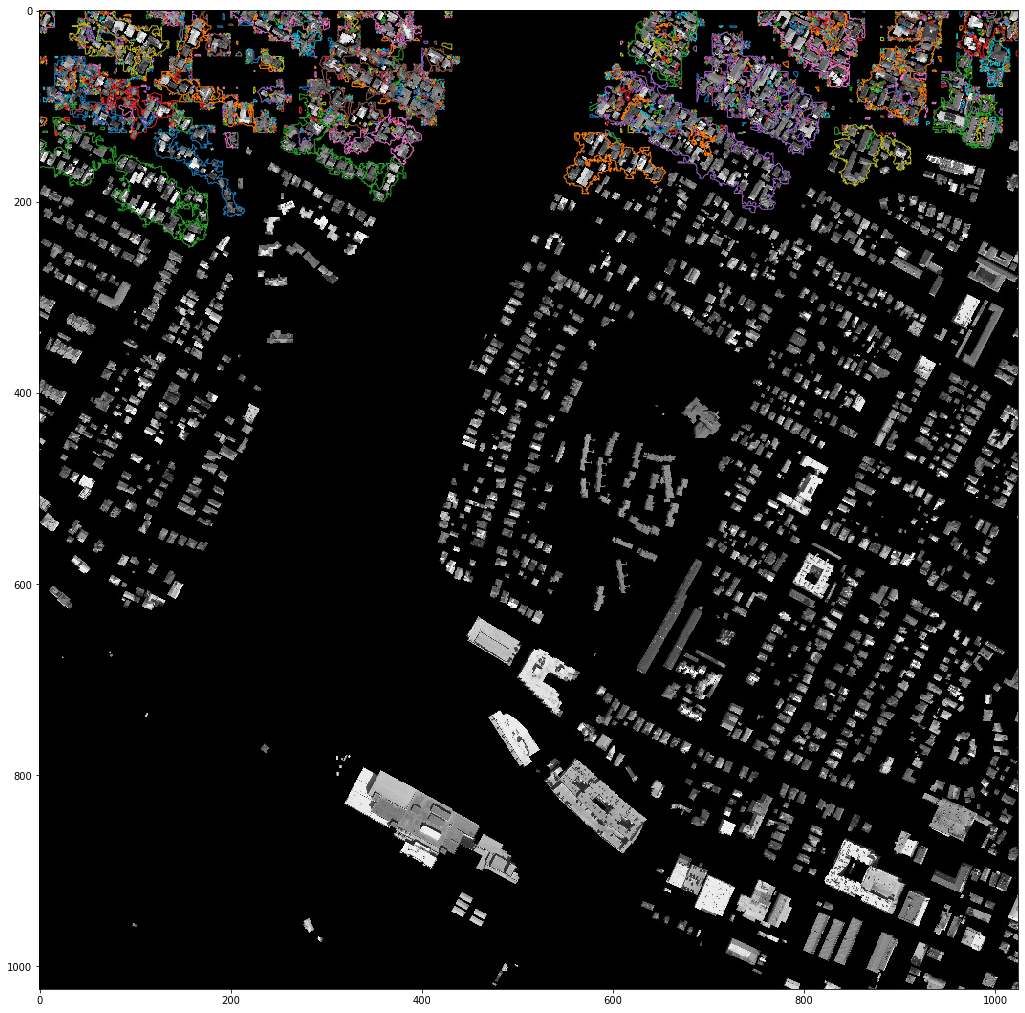

In [87]:
contours = measure.find_contours(test_image_gray, 0.8)

# Display the image and plot all contours found
fig, ax = plt.subplots(figsize=(12,12))

                       
ax.imshow(test_image_gray, cmap=plt.cm.gray)


for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=1)


#ax.axis('image')
axleft.set_xticks([])
axleft.set_yticks([])
axright.set_xticks([])
axright.set_yticks([])

### Using OpenCV to draw boxes

In [88]:
def __bound_contours(roi):
    """
        returns modified roi(non-destructive) and rectangles that founded by the algorithm.
        @roi region of interest to find contours
        @return (roi, rects)
    """

    roi_copy = roi.copy()
    roi_hsv = cv2.cvtColor(roi, cv2.COLOR_RGB2HSV)
    # filter black color
    mask1 = cv2.inRange(roi_hsv, np.array([0, 0, 0]), np.array([180, 255, 125]))
    mask1 = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
    mask1 = cv2.Canny(mask1, 100, 300)
    mask1 = cv2.GaussianBlur(mask1, (1, 1), 0)
    mask1 = cv2.Canny(mask1, 100, 300)

    # mask1 = cv2.morphologyEx(mask1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3)))

    # Find contours for detected portion of the image
    im2, cnts, hierarchy = cv2.findContours(mask1.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5] # get largest five contour area
    rects = []
    for c in cnts:
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)
        x, y, w, h = cv2.boundingRect(approx)
        if h >= 15:
            # if height is enough
            # create rectangle for bounding
            rect = (x, y, w, h)
            rects.append(rect)
            cv2.rectangle(roi_copy, (x, y), (x+w, y+h), (0, 255, 0), 1);

    return (roi_copy, rects) 

In [89]:
__bound_contours(test_image)

(array([[[  1,   3,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 95, 106, 108],
         [ 66,  78,  76],
         [ 78,  90,  86]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  2,   2,   0],
         ...,
         [102, 113, 117],
         [147, 159, 159],
         [124, 136, 134]],
 
        [[  1,   1,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [173, 186, 194],
         [173, 187, 190],
         [172, 186, 187]],
 
        ...,
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 57,  59,  56],
         [ 43,  45,  42],
         [ 47,  49,  46]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [ 91,  93,  90],
         [ 38,  40,  37],
         [165, 167, 164]],
 
        [[  0,   0,   0],
         [  0,   0,   0],
         [  0,   0,   0],
         ...,
         [107, 109, 106],
  

### Open CV Attempt #2

In [93]:
# read and scale down image
# wget https://bigsnarf.files.wordpress.com/2017/05/hammer.png #black and white
# wget https://i1.wp.com/images.hgmsites.net/hug/2011-volvo-s60_100323431_h.jpg
img = cv2.pyrDown(cv2.imread('../images/training/build_pos/0/austin11.jpg', cv2.IMREAD_UNCHANGED))

# threshold image
ret, threshed_img = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY),
                127, 255, cv2.THRESH_BINARY)
# find contours and get the external one

contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

#image, contours, hier = cv2.findContours(threshed_img, cv2.RETR_TREE,
#                cv2.CHAIN_APPROX_SIMPLE)

# with each contour, draw boundingRect in green
# a minAreaRect in red and
# a minEnclosingCircle in blue
for c in contours:
    # get the bounding rect
    x, y, w, h = cv2.boundingRect(c)
    # draw a green rectangle to visualize the bounding rect
    cv2.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # get the min area rect
    rect = cv2.minAreaRect(c)
    box = cv2.boxPoints(rect)
    # convert all coordinates floating point values to int
    box = np.int0(box)
    # draw a red 'nghien' rectangle
    cv2.drawContours(img, [box], 0, (0, 0, 255))

    # finally, get the min enclosing circle
    (x, y), radius = cv2.minEnclosingCircle(c)
    # convert all values to int
    center = (int(x), int(y))
    radius = int(radius)
    # and draw the circle in blue
    img = cv2.circle(img, center, radius, (255, 0, 0), 2)

print(len(contours))
cv2.drawContours(img, contours, -1, (255, 255, 0), 1)

cv2.imshow("contours", img)

cv2.imshow("contours", img)

while True:
    key = cv2.waitKey(1)
    if key == 27: #ESC key to break
        break

cv2.destroyAllWindows()

ValueError: too many values to unpack (expected 2)